In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!unzip '/content/drive/MyDrive/BP_data_Cabrini2017_New.zip'

Archive:  /content/drive/MyDrive/BP_data_Cabrini2017_New.zip
   creating: BP_data_Cabrini2017_New/
   creating: BP_data_Cabrini2017_New/01_NOV_09_F/
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09.xls  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09P1.txt  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09P2.txt  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09_CLEAR_INDX.xlsx  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_1.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_2.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_3.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_4.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_5.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_6.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test2_1.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test2_2.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test2_3.mat  
  inflat

In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.signal

def butter_lowpass_filter(signal, cutoff=5, fs=1000, order=3):
    nyquist = 0.4 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return scipy.signal.filtfilt(b, a, signal)

def process_mat_files(file_paths, fs=1000, cutoff=5, order=3, output_csv=None):
    all_rows = []
    row_info = []

    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        try:
            mat_contents = sio.loadmat(file_path)
            data = mat_contents['data']
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            continue

        for i in range(180):
            try:
                ecg_signal    = data[0][i][0][0][0][2]
                ppg_signal    = data[0][i][0][0][0][4]
                bioimp_signal = data[0][i][0][0][0][3]
            except Exception as e:
                print(f"Index error in file {file_path} at index {i}: {e}")
                continue

            ecg_filtered    = butter_lowpass_filter(ecg_signal, cutoff=cutoff, fs=fs, order=order)
            ppg_filtered    = butter_lowpass_filter(ppg_signal, cutoff=cutoff, fs=fs, order=order)
            bioimp_filtered = butter_lowpass_filter(bioimp_signal, cutoff=cutoff, fs=fs, order=order)

            combined_row = np.concatenate([ecg_filtered, ppg_filtered, bioimp_filtered])
            all_rows.append(combined_row)
            row_info.append((file_path, i))

    if len(all_rows) == 0:
        raise ValueError("No data was processed. Please check the file paths and data structure.")

    total_signal_length = len(all_rows[0])
    num_samples = total_signal_length // 3

    columns = ['file', 'case_index']
    ecg_columns    = [f'ecg_{j+1}' for j in range(num_samples)]
    ppg_columns    = [f'ppg_{j+1}' for j in range(num_samples)]
    bioimp_columns = [f'bioimp_{j+1}' for j in range(num_samples)]
    columns.extend(ecg_columns)
    columns.extend(ppg_columns)
    columns.extend(bioimp_columns)

    data_rows = []
    for (file_path, case_idx), signal_row in zip(row_info, all_rows):
        row = [file_path, case_idx] + list(signal_row)
        data_rows.append(row)

    df = pd.DataFrame(data_rows, columns=columns)

    if output_csv is not None:
        try:
            print(f"DataFrame successfully saved to {output_csv}")
        except Exception as e:
            print(f"Error saving CSV to {output_csv}: {e}")

    return df

In [ ]:
import os
import pandas as pd

def data_preparation_sbp_dbp(folder_path, columns):
    result = folder_path.split('/')[-1]
    name = '_'.join(result.split('_')[:-1])
    patient1_data = os.path.join(folder_path, f'{name}P1.txt')
    patient2_data = os.path.join(folder_path, f'{name}P2.txt')

    df1 = pd.read_csv(patient1_data, delimiter=';', skiprows=8)
    df1=df1.iloc[:,0:11]
    df1.columns = columns
    df2 = pd.read_csv(patient2_data, delimiter=';', skiprows=8)
    df2=df2.iloc[:,0:11]
    df2.columns = columns

    # Function to find available .mat files for a given patient
    def get_available_mat_files(folder, prefix):
        return sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.startswith(prefix) and f.endswith('.mat')])

    # Get available mat files for each patient
    p1_matfiles = get_available_mat_files(folder_path, 'test1_')
    p2_matfiles = get_available_mat_files(folder_path, 'test2_')

    # Process available .mat files
    df_combinedp1 = process_mat_files(p1_matfiles, fs=1000, cutoff=5, order=3, output_csv='combined_signals.csv') if p1_matfiles else pd.DataFrame()
    df_combinedp2 = process_mat_files(p2_matfiles, fs=1000, cutoff=5, order=3, output_csv='combined_signals.csv') if p2_matfiles else pd.DataFrame()

    # Filter out rows where 'Systolic (mmHg)' is 0
    df1 = df1[df1['Systolic (mmHg)'] != 0].reset_index(drop=True)
    df2 = df2[df2['Systolic (mmHg)'] != 0].reset_index(drop=True)

    # Trim patient data to match signal data length
    if not df_combinedp1.empty:
        df1_trimmed = df1.iloc[:len(df_combinedp1)]
        final_dfp1 = pd.concat([df_combinedp1, df1_trimmed], axis=1)
    else:
        final_dfp1 = pd.DataFrame()  # Empty DataFrame if no .mat files found

    if not df_combinedp2.empty:
        df2_trimmed = df2.iloc[:len(df_combinedp2)]
        final_dfp2 = pd.concat([df_combinedp2, df2_trimmed], axis=1)
    else:
        final_dfp2 = pd.DataFrame()  # Empty DataFrame if no .mat files found

    # Combine both patients' data
    combined_final_df_p1_p2 = pd.concat([final_dfp1, final_dfp2]) if not final_dfp1.empty or not final_dfp2.empty else pd.DataFrame()

    return combined_final_df_p1_p2


In [ ]:
import os
main_folder = "/content/BP_data_Cabrini2017_New"

all_folder_paths = []

for root, dirs, _ in os.walk(main_folder):
    for directory in dirs:
        full_path = os.path.join(root, directory)
        all_folder_paths.append(full_path)
print(all_folder_paths)


['/content/BP_data_Cabrini2017_New/25_OCT_10_M', '/content/BP_data_Cabrini2017_New/25_OCT_19_F', '/content/BP_data_Cabrini2017_New/01_NOV_13_F', '/content/BP_data_Cabrini2017_New/25_OCT_17_M', '/content/BP_data_Cabrini2017_New/01_NOV_09_F', '/content/BP_data_Cabrini2017_New/25_OCT_20_F', '/content/BP_data_Cabrini2017_New/25_OCT_11_M', '/content/BP_data_Cabrini2017_New/25_OCT_16_F', '/content/BP_data_Cabrini2017_New/18_OCT_14_M', '/content/BP_data_Cabrini2017_New/25_OCT_13_M', '/content/BP_data_Cabrini2017_New/01_NOV_15_F', '/content/BP_data_Cabrini2017_New/18_OCT_15_M']


In [ ]:
len(all_folder_paths)

12

In [ ]:
columns=['Time (s)', 'Systolic (mmHg)', 'Diastolic (mmHg)', 'Mean (mmHg)',
       'Heart rate (bpm)', 'Stroke Volume (ml)', 'LVET (ms)',
       'Pulse Interval (ms)', 'Maximum Slope (mmHg/s)',
       'Cardiac Output (l/min)', 'TPR (dyn.s/cm5)']

In [ ]:
len(columns)

11

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

df_list = []

# Process each folder path with a progress bar
for folder_path in tqdm(all_folder_paths, desc="Processing Folders", unit="folder"):
    df = data_preparation_sbp_dbp(folder_path, columns)
    df_list.append(df)

# Concatenate all data into a final DataFrame
df_data = pd.concat(df_list, ignore_index=True)

Processing Folders:   0%|          | 0/12 [00:00<?, ?folder/s]

Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_5.mat


Processing Folders:   8%|▊         | 1/12 [00:03<00:41,  3.81s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_6.mat


Processing Folders:  17%|█▋        | 2/12 [00:07<00:39,  3.94s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_6.mat


Processing Folders:  25%|██▌       | 3/12 [00:11<00:35,  3.90s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_6.mat


Processing Folders:  33%|███▎      | 4/12 [00:15<00:31,  3.96s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_6.mat


Processing Folders:  42%|████▏     | 5/12 [00:19<00:27,  3.95s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_6.mat


Processing Folders:  50%|█████     | 6/12 [00:23<00:23,  3.89s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_4.mat


Processing Folders:  58%|█████▊    | 7/12 [00:26<00:18,  3.65s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_6.mat


Processing Folders:  67%|██████▋   | 8/12 [00:30<00:14,  3.75s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_5.mat


Processing Folders:  75%|███████▌  | 9/12 [00:34<00:11,  3.70s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_6.mat


Processing Folders:  83%|████████▎ | 10/12 [00:38<00:07,  3.76s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_6.mat


Processing Folders:  92%|█████████▏| 11/12 [00:41<00:03,  3.81s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_4.mat


Processing Folders: 100%|██████████| 12/12 [00:45<00:00,  3.76s/folder]

DataFrame successfully saved to combined_signals.csv


In [ ]:
df_data

,file,case_index,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,...,Systolic (mmHg),Diastolic (mmHg),Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5)
0,/content/BP_data_Cabrini2017_New/25_OCT_10_M/t...,0,2267.986351,2267.979048,2267.960633,2267.931174,2267.890768,2267.839544,2267.777661,2267.705309,...,126,70,88,78,49.3,295,765,717,3.9,1371
1,/content/BP_data_Cabrini2017_New/25_OCT_10_M/t...,1,2185.488234,2187.244488,2188.996441,2190.742947,2192.482888,2194.215167,2195.938719,2197.652509,...,122,77,87,82,45.5,255,735,700,3.7,1405
2,/content/BP_data_Cabrini2017_New/25_OCT_10_M/t...,2,2206.108714,2208.018250,2209.920929,2211.815341,2213.700097,2215.573830,2217.435199,2219.282890,...,124,76,87,82,45.5,255,730,708,3.7,1396
3,/content/BP_data_Cabrini2017_New/25_OCT_10_M/t...,3,2192.780062,2194.448852,2196.106614,2197.752212,2199.384550,2201.002571,2202.605264,2204.191663,...,124,76,87,79,45.5,255,755,708,3.6,1444
4,/content/BP_data_Cabrini2017_New/25_OCT_10_M/t...,4,2190.988885,2192.889643,2194.790928,2196.691552,2198.590338,2200.486127,2202.377777,2204.264166,...,124,76,87,82,45.5,255,730,708,3.7,1396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,/content/BP_data_Cabrini2017_New/18_OCT_15_M/t...,175,2201.151388,2202.324517,2203.494550,2204.660554,2205.821602,2206.976776,2208.125170,2209.265890,...,161,79,105,94,124.8,260,640,1750,11.7,539
24836,/content/BP_data_Cabrini2017_New/18_OCT_15_M/t...,176,2232.930981,2232.904751,2232.876321,2232.845722,2232.812993,2232.778180,2232.741338,2232.702530,...,159,80,105,94,122.0,260,640,1679,11.4,551
24837,/content/BP_data_Cabrini2017_New/18_OCT_15_M/t...,177,2234.416909,2234.266932,2234.123736,2233.987657,2233.859031,2233.738186,2233.625449,2233.521139,...,162,80,106,92,125.8,260,650,1721,11.6,549
24838,/content/BP_data_Cabrini2017_New/18_OCT_15_M/t...,178,2240.718656,2240.968876,2241.218008,2241.465859,2241.712240,2241.956963,2242.199844,2242.440703,...,164,79,107,91,131.3,265,660,1792,11.9,537


In [ ]:
df_data=df_data.drop(['file','case_index','Time (s)'],axis=1)

In [ ]:
df_data

,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,ecg_10,...,Systolic (mmHg),Diastolic (mmHg),Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5)
0,2267.986351,2267.979048,2267.960633,2267.931174,2267.890768,2267.839544,2267.777661,2267.705309,2267.622709,2267.530115,...,126,70,88,78,49.3,295,765,717,3.9,1371
1,2185.488234,2187.244488,2188.996441,2190.742947,2192.482888,2194.215167,2195.938719,2197.652509,2199.355535,2201.046836,...,122,77,87,82,45.5,255,735,700,3.7,1405
2,2206.108714,2208.018250,2209.920929,2211.815341,2213.700097,2215.573830,2217.435199,2219.282890,2221.115620,2222.932143,...,124,76,87,82,45.5,255,730,708,3.7,1396
3,2192.780062,2194.448852,2196.106614,2197.752212,2199.384550,2201.002571,2202.605264,2204.191663,2205.760857,2207.311983,...,124,76,87,79,45.5,255,755,708,3.6,1444
4,2190.988885,2192.889643,2194.790928,2196.691552,2198.590338,2200.486127,2202.377777,2204.264166,2206.144194,2208.016787,...,124,76,87,82,45.5,255,730,708,3.7,1396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,2201.151388,2202.324517,2203.494550,2204.660554,2205.821602,2206.976776,2208.125170,2209.265890,2210.398057,2211.520813,...,161,79,105,94,124.8,260,640,1750,11.7,539
24836,2232.930981,2232.904751,2232.876321,2232.845722,2232.812993,2232.778180,2232.741338,2232.702530,2232.661825,2232.619303,...,159,80,105,94,122.0,260,640,1679,11.4,551
24837,2234.416909,2234.266932,2234.123736,2233.987657,2233.859031,2233.738186,2233.625449,2233.521139,2233.425571,2233.339049,...,162,80,106,92,125.8,260,650,1721,11.6,549
24838,2240.718656,2240.968876,2241.218008,2241.465859,2241.712240,2241.956963,2242.199844,2242.440703,2242.679366,2242.915663,...,164,79,107,91,131.3,265,660,1792,11.9,537


In [ ]:
df_data.shape

(24840, 3010)

In [ ]:
df=df_data.copy()

***Objective 1***

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

df=df_data.copy()

# Define feature categories
target_columns = ["Systolic (mmHg)", "Diastolic (mmHg)"]  # SBP and DBP as targets
medical_features = [
    "Mean (mmHg)", "Heart rate (bpm)", "Stroke Volume (ml)", "LVET (ms)",
    "Pulse Interval (ms)", "Maximum Slope (mmHg/s)", "Cardiac Output (l/min)", "TPR (dyn.s/cm5)"
]
ecg_features = [f"ecg_{i}" for i in range(1, 1001)]
ppg_features = [f"ppg_{i}" for i in range(1, 1001)]
bioimpedance_features = [f"bioimp_{i}" for i in range(1, 1001)]

# Function to extract key features from signals
def extract_signal_features(signal_values):
    peaks, _ = find_peaks(signal_values)
    num_peaks = len(peaks)
    peak_mean = np.mean(signal_values[peaks]) if num_peaks > 0 else 0
    peak_std = np.std(signal_values[peaks]) if num_peaks > 0 else 0
    min_val = np.min(signal_values)
    max_val = np.max(signal_values)
    return num_peaks, peak_mean, peak_std, min_val, max_val

# Extract features for ECG, PPG, and Bioimpedance
extracted_features = []

for index, row in df.iterrows():
    ecg_values = row[ecg_features].values
    ppg_values = row[ppg_features].values
    bioimpedance_values = row[bioimpedance_features].values

    ecg_feats = extract_signal_features(ecg_values)
    ppg_feats = extract_signal_features(ppg_values)
    bio_feats = extract_signal_features(bioimpedance_values)

    extracted_features.append(list(ecg_feats) + list(ppg_feats) + list(bio_feats))

# Create new DataFrame with extracted features
feature_columns = [
    "ecg_peaks", "ecg_peak_mean", "ecg_peak_std", "ecg_min", "ecg_max",
    "ppg_peaks", "ppg_peak_mean", "ppg_peak_std", "ppg_min", "ppg_max",
    "bio_peaks", "bio_peak_mean", "bio_peak_std", "bio_min", "bio_max"
]

df_extracted = pd.DataFrame(extracted_features, columns=feature_columns)

# Combine with medical features and target columns
final_df1 = pd.concat([df[medical_features], df_extracted, df[target_columns]], axis=1)


In [ ]:
final_df1

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),ecg_peaks,ecg_peak_mean,...,ppg_peak_std,ppg_min,ppg_max,bio_peaks,bio_peak_mean,bio_peak_std,bio_min,bio_max,Systolic (mmHg),Diastolic (mmHg)
0,88,78,49.3,295,765,717,3.9,1371,5,2280.754779,...,245.805874,1905.296122,2468.298573,2,1672.131505,40.060711,1416.024497,1712.192216,126,70
1,87,82,45.5,255,735,700,3.7,1405,4,2281.915392,...,221.220794,1905.024090,2455.460870,2,1679.000322,76.613356,1463.530747,1755.613678,122,77
2,87,82,45.5,255,730,708,3.7,1396,4,2281.634325,...,264.206107,1902.764404,2484.224618,1,1683.899034,0.000000,1394.602652,1744.187609,124,76
3,87,79,45.5,255,755,708,3.6,1444,5,2276.754567,...,228.785510,1881.598316,2429.229515,1,1344.674567,0.000000,1224.241967,1444.884238,124,76
4,87,82,45.5,255,730,708,3.7,1396,5,2281.105477,...,277.973669,1907.046443,2578.146441,2,1786.275177,87.792036,1536.505045,1874.067213,124,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,105,94,124.8,260,640,1750,11.7,539,4,2241.353223,...,0.000000,1784.775555,2538.841386,2,1593.537138,161.807688,1283.154881,1755.344827,161,79
24836,105,94,122.0,260,640,1679,11.4,551,3,2246.461883,...,0.000000,1584.975442,2514.496527,1,2082.403208,0.000000,1729.234096,2082.403208,159,80
24837,106,92,125.8,260,650,1721,11.6,549,5,2249.440498,...,241.067181,1754.456232,2495.725811,2,2072.787455,39.174350,1942.443910,2111.961805,162,80
24838,107,91,131.3,265,660,1792,11.9,537,5,2246.970042,...,225.310064,1816.722950,2409.975668,1,1768.164163,0.000000,1212.908064,1998.004552,164,79


In [ ]:
final_df1=final_df1.dropna(axis=0)

In [ ]:
final_df1.isnull().sum().sum()

0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(final_df1.drop(columns=target_columns))
y = scaler_y.fit_transform(final_df1[target_columns])

# Define test set size
test_size = 3583

# Split dataset: First, separate the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Determine the size of training and validation sets
val_size = 0.125  # Since we need 10% validation out of the remaining data

# Split remaining data into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

# Print dataset sizes to verify
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 18599
Validation set size: 2658
Testing set size: 3583


In [ ]:
# Reshape data for CNN (1D convolution expects (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define 1D CNN Model
model = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='linear')  # Predicting SBP and DBP
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    sde = np.std(y_true - y_pred)
    return mse, rmse, mae, sde

# Compute metrics for SBP and DBP
metrics_sbp = calculate_metrics(y_test_unscaled[:, 0], y_pred[:, 0])
metrics_dbp = calculate_metrics(y_test_unscaled[:, 1], y_pred[:, 1])

# Print metrics
print(f"SBP - MSE: {metrics_sbp[0]:.4f}, RMSE: {metrics_sbp[1]:.4f}, MAE: {metrics_sbp[2]:.4f}, SDE: {metrics_sbp[3]:.4f}")
print(f"DBP - MSE: {metrics_dbp[0]:.4f}, RMSE: {metrics_dbp[1]:.4f}, MAE: {metrics_dbp[2]:.4f}, SDE: {metrics_dbp[3]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.4569 - mae: 0.4892 - val_loss: 0.0896 - val_mae: 0.2209
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1163 - mae: 0.2527 - val_loss: 0.0656 - val_mae: 0.1751
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0945 - mae: 0.2277 - val_loss: 0.0556 - val_mae: 0.1580
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0875 - mae: 0.2169 - val_loss: 0.0590 - val_mae: 0.1644
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0831 - mae: 0.2110 - val_loss: 0.0568 - val_mae: 0.1649
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0816 - mae: 0.2099 - val_loss: 0.0554 - val_mae: 0.1586
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0779 - mae: 0.2051 - val_loss: 0.0596 - val_mae: 0.1629
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0787 - mae: 0.2060 - val_loss: 0.0501 - val_mae: 0.1483
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

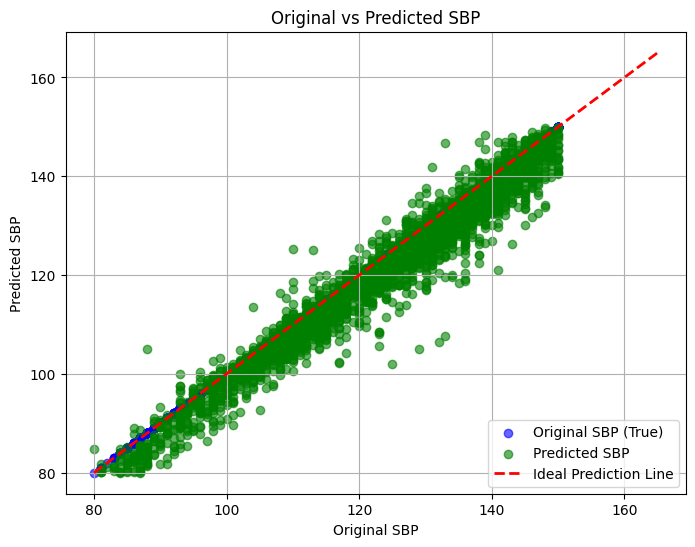

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the SBP valid range
sbp_min, sbp_max = 80, 150

# Filter based on original values
valid_indices_original = (y_test_unscaled[:, 0] >= sbp_min) & (y_test_unscaled[:, 0] <= sbp_max)
y_test_filtered_original = y_test_unscaled[valid_indices_original]
y_pred_filtered_original = y_pred[valid_indices_original]

# Filter based on predicted values
valid_indices_pred = (y_pred_filtered_original[:, 0] >= sbp_min) & (y_pred_filtered_original[:, 0] <= sbp_max)
y_test_filtered_final = y_test_filtered_original[valid_indices_pred]
y_pred_filtered_final = y_pred_filtered_original[valid_indices_pred]

# Create Scatter Plot with Different Colors
plt.figure(figsize=(8, 6))

# Original SBP (Ground Truth) in **Blue**
plt.scatter(y_test_filtered_final[:, 0], y_test_filtered_final[:, 0],
            alpha=0.6, label="Original SBP (True)", color='blue', marker='o')

# Predicted SBP in **Green**
plt.scatter(y_test_filtered_final[:, 0], y_pred_filtered_final[:, 0],
            alpha=0.6, label="Predicted SBP", color='green', marker='o')

# Ideal Prediction Line in **Red Dashed**
x_vals = np.linspace(min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0]) + 15, 50)
plt.plot(x_vals, x_vals, color='red', linestyle='dashed', linewidth=2, label="Ideal Prediction Line")

# Labels & Title
plt.xlabel("Original SBP")
plt.ylabel("Predicted SBP")
plt.title("Original vs Predicted SBP")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


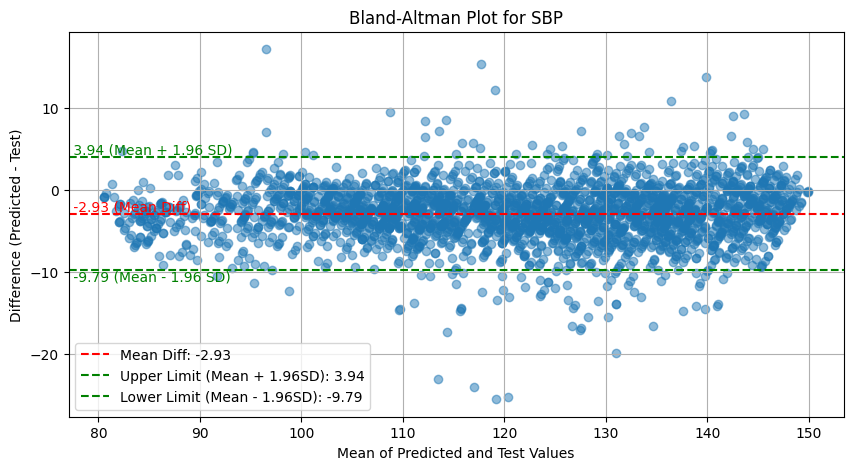

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SBP values (Filtered)
predicted_sbp_filtered = y_pred_filtered_final[:, 0]
test_sbp_filtered = y_test_filtered_final[:, 0]

# Function to create Bland-Altman plot with annotations at the start of lines
def bland_altman_plot(predicted, test, title):
    mean_vals = np.mean(np.array([predicted, test]), axis=0)
    diff_vals = predicted - test
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 5))
    plt.scatter(mean_vals, diff_vals, alpha=0.5)

    # Plot the mean difference line
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.2f}')

    # Plot the upper and lower limit of agreement
    plt.axhline(upper_limit, color='green', linestyle='--', label=f'Upper Limit (Mean + 1.96SD): {upper_limit:.2f}')
    plt.axhline(lower_limit, color='green', linestyle='--', label=f'Lower Limit (Mean - 1.96SD): {lower_limit:.2f}')

    # Get x-axis limit to position text at the start
    x_min, _ = plt.xlim()

    # Add text annotations at the start of each line
    plt.text(x_min, upper_limit, f' {upper_limit:.2f} (Mean + 1.96 SD)',
             verticalalignment='bottom', fontsize=10, color='green')
    plt.text(x_min, lower_limit, f' {lower_limit:.2f} (Mean - 1.96 SD)',
             verticalalignment='top', fontsize=10, color='green')
    plt.text(x_min, mean_diff, f' {mean_diff:.2f} (Mean Diff)',
             verticalalignment='bottom', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel('Mean of Predicted and Test Values')
    plt.ylabel('Difference (Predicted - Test)')
    plt.legend()
    plt.grid()
    plt.show()

# Generate Bland-Altman plot for SBP (Filtered)
bland_altman_plot(predicted_sbp_filtered, test_sbp_filtered, 'Bland-Altman Plot for SBP')


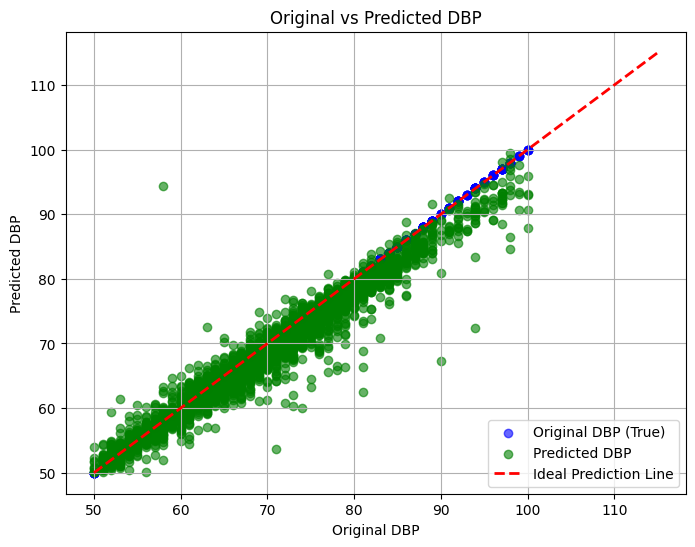

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the DBP valid range
dbp_min, dbp_max = 50, 100

# Filter based on original values
valid_indices_original_dbp = (y_test_unscaled[:, 1] >= dbp_min) & (y_test_unscaled[:, 1] <= dbp_max)
y_test_filtered_original_dbp = y_test_unscaled[valid_indices_original_dbp]
y_pred_filtered_original_dbp = y_pred[valid_indices_original_dbp]

# Filter based on predicted values
valid_indices_pred_dbp = (y_pred_filtered_original_dbp[:, 1] >= dbp_min) & (y_pred_filtered_original_dbp[:, 1] <= dbp_max)
y_test_filtered_final_dbp = y_test_filtered_original_dbp[valid_indices_pred_dbp]
y_pred_filtered_final_dbp = y_pred_filtered_original_dbp[valid_indices_pred_dbp]

# Create Scatter Plot with Different Colors
plt.figure(figsize=(8, 6))

# Original DBP (Ground Truth) in **Blue**
plt.scatter(y_test_filtered_final_dbp[:, 1], y_test_filtered_final_dbp[:, 1],
            alpha=0.6, label="Original DBP (True)", color='blue', marker='o')

# Predicted DBP in **Green**
plt.scatter(y_test_filtered_final_dbp[:, 1], y_pred_filtered_final_dbp[:, 1],
            alpha=0.6, label="Predicted DBP", color='green', marker='o')

# Ideal Prediction Line in **Red Dashed**
x_vals_dbp = np.linspace(min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1]) + 15, 50)
plt.plot(x_vals_dbp, x_vals_dbp, color='red', linestyle='dashed', linewidth=2, label="Ideal Prediction Line")

# Labels & Title
plt.xlabel("Original DBP")
plt.ylabel("Predicted DBP")
plt.title("Original vs Predicted DBP")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


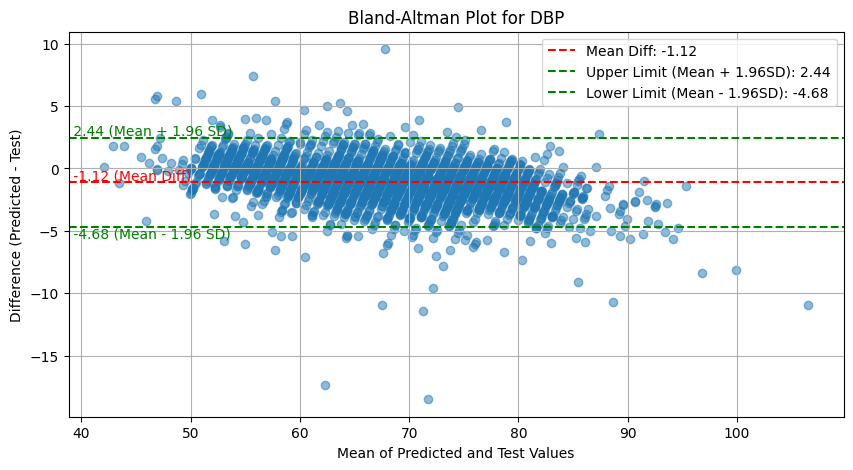

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SBP values (Filtered)
predicted_sbp_filtered = y_pred_filtered_final[:, 1]
test_sbp_filtered = y_test_filtered_final[:, 1]

# Function to create Bland-Altman plot with annotations at the start of lines
def bland_altman_plot(predicted, test, title):
    mean_vals = np.mean(np.array([predicted, test]), axis=0)
    diff_vals = predicted - test
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 5))
    plt.scatter(mean_vals, diff_vals, alpha=0.5)

    # Plot the mean difference line
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.2f}')

    # Plot the upper and lower limit of agreement
    plt.axhline(upper_limit, color='green', linestyle='--', label=f'Upper Limit (Mean + 1.96SD): {upper_limit:.2f}')
    plt.axhline(lower_limit, color='green', linestyle='--', label=f'Lower Limit (Mean - 1.96SD): {lower_limit:.2f}')

    # Get x-axis limit to position text at the start
    x_min, _ = plt.xlim()

    # Add text annotations at the start of each line
    plt.text(x_min, upper_limit, f' {upper_limit:.2f} (Mean + 1.96 SD)',
             verticalalignment='bottom', fontsize=10, color='green')
    plt.text(x_min, lower_limit, f' {lower_limit:.2f} (Mean - 1.96 SD)',
             verticalalignment='top', fontsize=10, color='green')
    plt.text(x_min, mean_diff, f' {mean_diff:.2f} (Mean Diff)',
             verticalalignment='bottom', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel('Mean of Predicted and Test Values')
    plt.ylabel('Difference (Predicted - Test)')
    plt.legend()
    plt.grid()
    plt.show()

# Generate Bland-Altman plot for SBP (Filtered)
bland_altman_plot(predicted_sbp_filtered, test_sbp_filtered, 'Bland-Altman Plot for DBP')


***Objective 3***

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.6 MB/s eta 0:00:00


In [ ]:
df

,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,ecg_10,...,Systolic (mmHg),Diastolic (mmHg),Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5)
0,2267.986351,2267.979048,2267.960633,2267.931174,2267.890768,2267.839544,2267.777661,2267.705309,2267.622709,2267.530115,...,126,70,88,78,49.3,295,765,717,3.9,1371
1,2185.488234,2187.244488,2188.996441,2190.742947,2192.482888,2194.215167,2195.938719,2197.652509,2199.355535,2201.046836,...,122,77,87,82,45.5,255,735,700,3.7,1405
2,2206.108714,2208.018250,2209.920929,2211.815341,2213.700097,2215.573830,2217.435199,2219.282890,2221.115620,2222.932143,...,124,76,87,82,45.5,255,730,708,3.7,1396
3,2192.780062,2194.448852,2196.106614,2197.752212,2199.384550,2201.002571,2202.605264,2204.191663,2205.760857,2207.311983,...,124,76,87,79,45.5,255,755,708,3.6,1444
4,2190.988885,2192.889643,2194.790928,2196.691552,2198.590338,2200.486127,2202.377777,2204.264166,2206.144194,2208.016787,...,124,76,87,82,45.5,255,730,708,3.7,1396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,2201.151388,2202.324517,2203.494550,2204.660554,2205.821602,2206.976776,2208.125170,2209.265890,2210.398057,2211.520813,...,161,79,105,94,124.8,260,640,1750,11.7,539
24836,2232.930981,2232.904751,2232.876321,2232.845722,2232.812993,2232.778180,2232.741338,2232.702530,2232.661825,2232.619303,...,159,80,105,94,122.0,260,640,1679,11.4,551
24837,2234.416909,2234.266932,2234.123736,2233.987657,2233.859031,2233.738186,2233.625449,2233.521139,2233.425571,2233.339049,...,162,80,106,92,125.8,260,650,1721,11.6,549
24838,2240.718656,2240.968876,2241.218008,2241.465859,2241.712240,2241.956963,2242.199844,2242.440703,2242.679366,2242.915663,...,164,79,107,91,131.3,265,660,1792,11.9,537


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pywt

# Define feature categories
target_columns = ["Systolic (mmHg)", "Diastolic (mmHg)"]  # SBP and DBP as targets
medical_features = [
    "Mean (mmHg)", "Heart rate (bpm)", "Stroke Volume (ml)", "LVET (ms)",
    "Pulse Interval (ms)", "Maximum Slope (mmHg/s)", "Cardiac Output (l/min)", "TPR (dyn.s/cm5)"
]
ecg_features = [f"ecg_{i}" for i in range(1, 1001)]
ppg_features = [f"ppg_{i}" for i in range(1, 1001)]
bioimpedance_features = [f"bioimp_{i}" for i in range(1, 1001)]

# Function to apply Butterworth low-pass filter
def butter_lowpass_filter(signal, cutoff=5, fs=1000, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Function to apply wavelet denoising
def wavelet_denoising(signal, wavelet="db4", level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-level]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Function to extract key features from signals
def extract_signal_features(signal_values):
    peaks, _ = find_peaks(signal_values)
    num_peaks = len(peaks)
    peak_mean = np.mean(signal_values[peaks]) if num_peaks > 0 else 0
    peak_std = np.std(signal_values[peaks]) if num_peaks > 0 else 0
    min_val = np.min(signal_values)
    max_val = np.max(signal_values)
    return num_peaks, peak_mean, peak_std, min_val, max_val

# Apply denoising and extract features
extracted_features = []
for index, row in df_data.iterrows():
    ecg_values = butter_lowpass_filter(row[ecg_features].values)
    ppg_values = wavelet_denoising(row[ppg_features].values)

    ecg_feats = extract_signal_features(ecg_values)
    ppg_feats = extract_signal_features(ppg_values)

    extracted_features.append(list(ecg_feats) + list(ppg_feats))

# Create new DataFrame with extracted features
feature_columns = [
    "ecg_peaks", "ecg_peak_mean", "ecg_peak_std", "ecg_min", "ecg_max",
    "ppg_peaks", "ppg_peak_mean", "ppg_peak_std", "ppg_min", "ppg_max"
]

df_extracted = pd.DataFrame(extracted_features, columns=feature_columns)

# Combine with medical features and target columns
final_df3 = pd.concat([df[medical_features], df_extracted, df[target_columns]], axis=1)


In [ ]:
final_df3

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),ecg_peaks,ecg_peak_mean,ecg_peak_std,ecg_min,ecg_max,ppg_peaks,ppg_peak_mean,ppg_peak_std,ppg_min,ppg_max,Systolic (mmHg),Diastolic (mmHg)
0,88,78,49.3,295,765,717,3.9,1371,3,2282.235072,6.760076,2256.985042,2290.381078,3,2121.160090,245.808179,1905.295301,2468.303401,126,70
1,87,82,45.5,255,735,700,3.7,1405,2,2283.531312,7.036128,2191.900142,2290.567441,4,2231.578417,221.221766,1905.022992,2455.469158,122,77
2,87,82,45.5,255,730,708,3.7,1396,3,2281.604815,4.383681,2214.644896,2287.776038,2,2220.017212,264.204752,1902.764389,2484.221965,124,76
3,87,79,45.5,255,755,708,3.6,1444,4,2276.414021,5.759088,2197.860775,2281.954106,3,2105.684578,228.782387,1881.595576,2429.223335,124,76
4,87,82,45.5,255,730,708,3.7,1396,4,2282.626293,8.772631,2199.807079,2294.167227,3,2336.035002,277.974004,1907.045477,2578.149913,124,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,105,94,124.8,260,640,1750,11.7,539,4,2240.268260,3.034435,2206.343034,2243.616824,1,2522.318366,0.000000,1784.776930,2538.822789,161,79
24836,105,94,122.0,260,640,1679,11.4,551,3,2245.973286,0.827808,2231.431806,2246.977652,1,1898.122190,0.000000,1584.978535,2511.664495,159,80
24837,106,92,125.8,260,650,1721,11.6,549,3,2249.431340,1.921030,2235.104404,2250.918395,2,2254.659636,241.069359,1754.456852,2495.728995,162,80
24838,107,91,131.3,265,660,1792,11.9,537,3,2248.324431,2.159138,2235.576724,2250.810982,3,2091.343408,225.311515,1816.725213,2409.977307,164,79


In [ ]:
final_df3=final_df3.dropna(axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(final_df3.drop(columns=target_columns))
y = scaler_y.fit_transform(final_df3[target_columns])

# Define test set size
test_size = 3583

# Split dataset: First, separate the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Determine validation set size (10% of remaining data)
val_size = 0.125  # 10% validation from remaining data

# Split remaining data into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)


# Reshape data for CNN (1D convolution expects (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define 1D CNN Model
model3 = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='linear')  # Predicting SBP and DBP
])

# Compile the model
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred_scaled = model3.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    sde = np.std(y_true - y_pred)
    return mse, rmse, mae, sde

# Compute metrics for SBP and DBP
metrics_sbp = calculate_metrics(y_test_unscaled[:, 0], y_pred[:, 0])
metrics_dbp = calculate_metrics(y_test_unscaled[:, 1], y_pred[:, 1])

# Print metrics
print(f"SBP - MSE: {metrics_sbp[0]:.4f}, RMSE: {metrics_sbp[1]:.4f}, MAE: {metrics_sbp[2]:.4f}, SDE: {metrics_sbp[3]:.4f}")
print(f"DBP - MSE: {metrics_dbp[0]:.4f}, RMSE: {metrics_dbp[1]:.4f}, MAE: {metrics_dbp[2]:.4f}, SDE: {metrics_dbp[3]:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.4056 - mae: 0.4574 - val_loss: 0.0687 - val_mae: 0.1804
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1115 - mae: 0.2471 - val_loss: 0.0710 - val_mae: 0.1892
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1049 - mae: 0.2362 - val_loss: 0.0711 - val_mae: 0.1944
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0877 - mae: 0.2187 - val_loss: 0.0594 - val_mae: 0.1670
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0824 - mae: 0.2089 - val_loss: 0.0534 - val_mae: 0.1553
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0813 - mae: 0.2081 - val_loss: 0.0471 - val_mae: 0.1409
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0769 - mae: 0.2038 - val_loss: 0.0538 - val_mae: 0.1452
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0764 - mae: 0.2014 - val_loss: 0.0484 - val_mae: 0.1436
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0741 

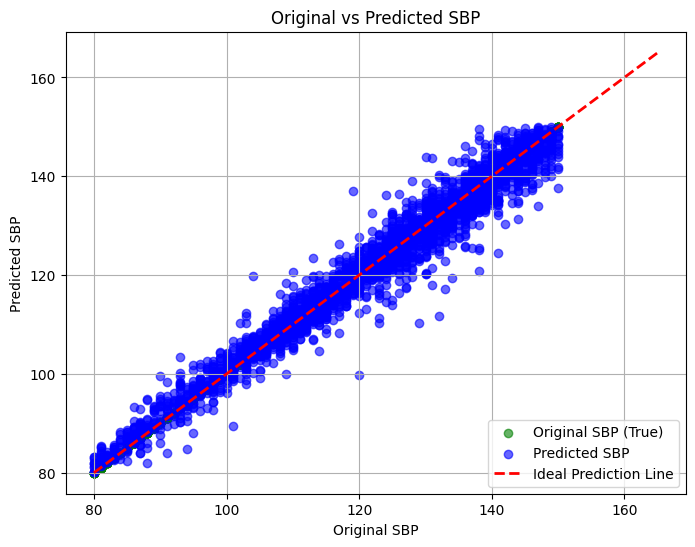

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the SBP valid range
sbp_min, sbp_max = 80, 150

# Filter based on original values
valid_indices_original = (y_test_unscaled[:, 0] >= sbp_min) & (y_test_unscaled[:, 0] <= sbp_max)
y_test_filtered_original = y_test_unscaled[valid_indices_original]
y_pred_filtered_original = y_pred[valid_indices_original]

# Filter based on predicted values
valid_indices_pred = (y_pred_filtered_original[:, 0] >= sbp_min) & (y_pred_filtered_original[:, 0] <= sbp_max)
y_test_filtered_final = y_test_filtered_original[valid_indices_pred]
y_pred_filtered_final = y_pred_filtered_original[valid_indices_pred]

# Create Scatter Plot with Different Colors
plt.figure(figsize=(8, 6))

# Original SBP (Ground Truth) in **Blue**
plt.scatter(y_test_filtered_final[:, 0], y_test_filtered_final[:, 0],
            alpha=0.6, label="Original SBP (True)", color='green', marker='o')

# Predicted SBP in **Green**
plt.scatter(y_test_filtered_final[:, 0], y_pred_filtered_final[:, 0],
            alpha=0.6, label="Predicted SBP", color='blue', marker='o')

# Ideal Prediction Line in **Red Dashed**
x_vals = np.linspace(min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0]) + 15, 50)
plt.plot(x_vals, x_vals, color='red', linestyle='dashed', linewidth=2, label="Ideal Prediction Line")

# Labels & Title
plt.xlabel("Original SBP")
plt.ylabel("Predicted SBP")
plt.title("Original vs Predicted SBP")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


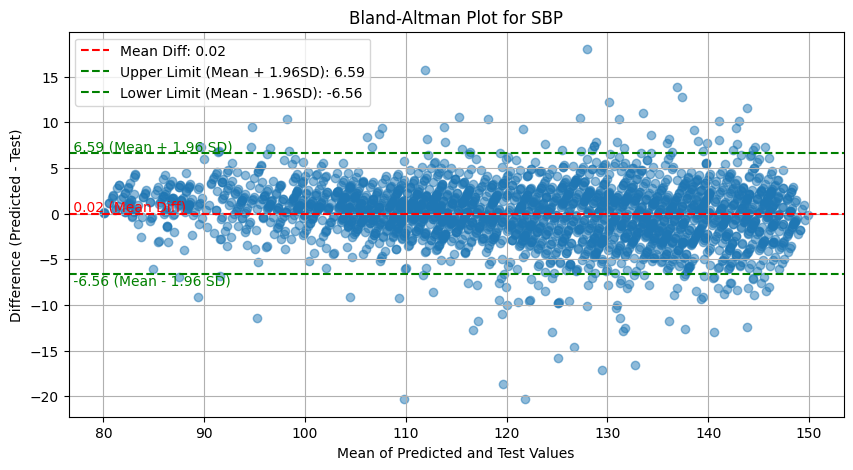

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SBP values (Filtered)
predicted_sbp_filtered = y_pred_filtered_final[:, 0]
test_sbp_filtered = y_test_filtered_final[:, 0]

# Function to create Bland-Altman plot with annotations at the start of lines
def bland_altman_plot(predicted, test, title):
    mean_vals = np.mean(np.array([predicted, test]), axis=0)
    diff_vals = predicted - test
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 5))
    plt.scatter(mean_vals, diff_vals,  alpha=0.5)

    # Plot the mean difference line
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.2f}')

    # Plot the upper and lower limit of agreement
    plt.axhline(upper_limit, color='green', linestyle='--', label=f'Upper Limit (Mean + 1.96SD): {upper_limit:.2f}')
    plt.axhline(lower_limit, color='green', linestyle='--', label=f'Lower Limit (Mean - 1.96SD): {lower_limit:.2f}')

    # Get x-axis limit to position text at the start
    x_min, _ = plt.xlim()

    # Add text annotations at the start of each line
    plt.text(x_min, upper_limit, f' {upper_limit:.2f} (Mean + 1.96 SD)',
             verticalalignment='bottom', fontsize=10, color='green')
    plt.text(x_min, lower_limit, f' {lower_limit:.2f} (Mean - 1.96 SD)',
             verticalalignment='top', fontsize=10, color='green')
    plt.text(x_min, mean_diff, f' {mean_diff:.2f} (Mean Diff)',
             verticalalignment='bottom', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel('Mean of Predicted and Test Values')
    plt.ylabel('Difference (Predicted - Test)')
    plt.legend()
    plt.grid()
    plt.show()

# Generate Bland-Altman plot for SBP (Filtered)
bland_altman_plot(predicted_sbp_filtered, test_sbp_filtered, 'Bland-Altman Plot for SBP')


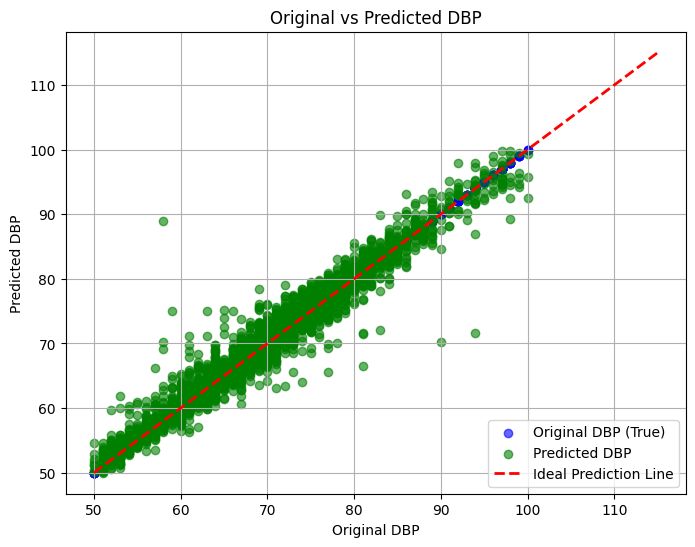

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the DBP valid range
dbp_min, dbp_max = 50, 100

# Filter based on original values
valid_indices_original_dbp = (y_test_unscaled[:, 1] >= dbp_min) & (y_test_unscaled[:, 1] <= dbp_max)
y_test_filtered_original_dbp = y_test_unscaled[valid_indices_original_dbp]
y_pred_filtered_original_dbp = y_pred[valid_indices_original_dbp]

# Filter based on predicted values
valid_indices_pred_dbp = (y_pred_filtered_original_dbp[:, 1] >= dbp_min) & (y_pred_filtered_original_dbp[:, 1] <= dbp_max)
y_test_filtered_final_dbp = y_test_filtered_original_dbp[valid_indices_pred_dbp]
y_pred_filtered_final_dbp = y_pred_filtered_original_dbp[valid_indices_pred_dbp]

# Create Scatter Plot with Different Colors
plt.figure(figsize=(8, 6))

# Original DBP (Ground Truth) in **Blue**
plt.scatter(y_test_filtered_final_dbp[:, 1], y_test_filtered_final_dbp[:, 1],
            alpha=0.6, label="Original DBP (True)", color='blue', marker='o')

# Predicted DBP in **Green**
plt.scatter(y_test_filtered_final_dbp[:, 1], y_pred_filtered_final_dbp[:, 1],
            alpha=0.6, label="Predicted DBP", color='green', marker='o')

# Ideal Prediction Line in **Red Dashed**
x_vals_dbp = np.linspace(min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1]) + 15, 50)
plt.plot(x_vals_dbp, x_vals_dbp, color='red', linestyle='dashed', linewidth=2, label="Ideal Prediction Line")

# Labels & Title
plt.xlabel("Original DBP")
plt.ylabel("Predicted DBP")
plt.title("Original vs Predicted DBP")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


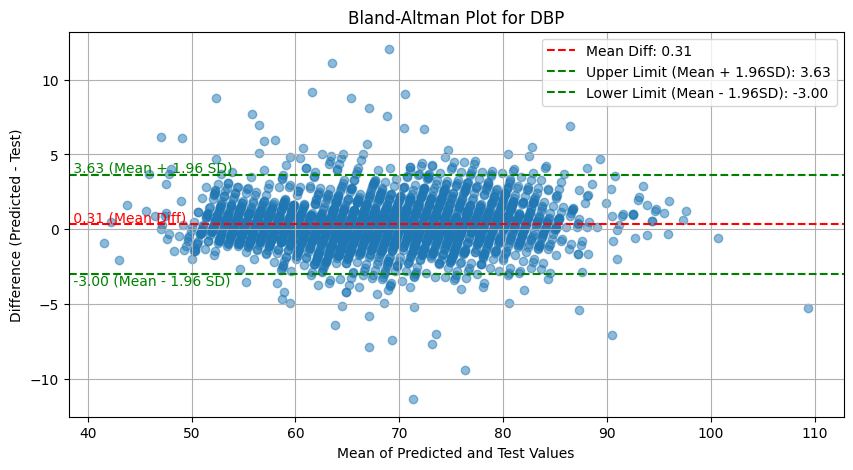

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SBP values (Filtered)
predicted_sbp_filtered = y_pred_filtered_final[:, 1]
test_sbp_filtered = y_test_filtered_final[:, 1]

# Function to create Bland-Altman plot with annotations at the start of lines
def bland_altman_plot(predicted, test, title):
    mean_vals = np.mean(np.array([predicted, test]), axis=0)
    diff_vals = predicted - test
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 5))
    plt.scatter(mean_vals, diff_vals, alpha=0.5)

    # Plot the mean difference line
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.2f}')

    # Plot the upper and lower limit of agreement
    plt.axhline(upper_limit, color='green', linestyle='--', label=f'Upper Limit (Mean + 1.96SD): {upper_limit:.2f}')
    plt.axhline(lower_limit, color='green', linestyle='--', label=f'Lower Limit (Mean - 1.96SD): {lower_limit:.2f}')

    # Get x-axis limit to position text at the start
    x_min, _ = plt.xlim()

    # Add text annotations at the start of each line
    plt.text(x_min, upper_limit, f' {upper_limit:.2f} (Mean + 1.96 SD)',
             verticalalignment='bottom', fontsize=10, color='green')
    plt.text(x_min, lower_limit, f' {lower_limit:.2f} (Mean - 1.96 SD)',
             verticalalignment='top', fontsize=10, color='green')
    plt.text(x_min, mean_diff, f' {mean_diff:.2f} (Mean Diff)',
             verticalalignment='bottom', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel('Mean of Predicted and Test Values')
    plt.ylabel('Difference (Predicted - Test)')
    plt.legend()
    plt.grid()
    plt.show()

# Generate Bland-Altman plot for SBP (Filtered)
bland_altman_plot(predicted_sbp_filtered, test_sbp_filtered, 'Bland-Altman Plot for DBP')


***Objective 2***

In [ ]:
final_df1

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),ecg_peaks,ecg_peak_mean,...,ppg_peak_std,ppg_min,ppg_max,bio_peaks,bio_peak_mean,bio_peak_std,bio_min,bio_max,Systolic (mmHg),Diastolic (mmHg)
0,88,78,49.3,295,765,717,3.9,1371,5,2280.754779,...,245.805874,1905.296122,2468.298573,2,1672.131505,40.060711,1416.024497,1712.192216,126,70
1,87,82,45.5,255,735,700,3.7,1405,4,2281.915392,...,221.220794,1905.024090,2455.460870,2,1679.000322,76.613356,1463.530747,1755.613678,122,77
2,87,82,45.5,255,730,708,3.7,1396,4,2281.634325,...,264.206107,1902.764404,2484.224618,1,1683.899034,0.000000,1394.602652,1744.187609,124,76
3,87,79,45.5,255,755,708,3.6,1444,5,2276.754567,...,228.785510,1881.598316,2429.229515,1,1344.674567,0.000000,1224.241967,1444.884238,124,76
4,87,82,45.5,255,730,708,3.7,1396,5,2281.105477,...,277.973669,1907.046443,2578.146441,2,1786.275177,87.792036,1536.505045,1874.067213,124,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,105,94,124.8,260,640,1750,11.7,539,4,2241.353223,...,0.000000,1784.775555,2538.841386,2,1593.537138,161.807688,1283.154881,1755.344827,161,79
24836,105,94,122.0,260,640,1679,11.4,551,3,2246.461883,...,0.000000,1584.975442,2514.496527,1,2082.403208,0.000000,1729.234096,2082.403208,159,80
24837,106,92,125.8,260,650,1721,11.6,549,5,2249.440498,...,241.067181,1754.456232,2495.725811,2,2072.787455,39.174350,1942.443910,2111.961805,162,80
24838,107,91,131.3,265,660,1792,11.9,537,5,2246.970042,...,225.310064,1816.722950,2409.975668,1,1768.164163,0.000000,1212.908064,1998.004552,164,79


In [ ]:
columns_to_remove = [col for col in final_df1.columns if col.startswith('ppg') or col.startswith('ecg')]
df2 = final_df1.drop(columns=columns_to_remove)


In [ ]:
df2

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),bio_peaks,bio_peak_mean,bio_peak_std,bio_min,bio_max,Systolic (mmHg),Diastolic (mmHg)
0,88,78,49.3,295,765,717,3.9,1371,2,1672.131505,40.060711,1416.024497,1712.192216,126,70
1,87,82,45.5,255,735,700,3.7,1405,2,1679.000322,76.613356,1463.530747,1755.613678,122,77
2,87,82,45.5,255,730,708,3.7,1396,1,1683.899034,0.000000,1394.602652,1744.187609,124,76
3,87,79,45.5,255,755,708,3.6,1444,1,1344.674567,0.000000,1224.241967,1444.884238,124,76
4,87,82,45.5,255,730,708,3.7,1396,2,1786.275177,87.792036,1536.505045,1874.067213,124,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,105,94,124.8,260,640,1750,11.7,539,2,1593.537138,161.807688,1283.154881,1755.344827,161,79
24836,105,94,122.0,260,640,1679,11.4,551,1,2082.403208,0.000000,1729.234096,2082.403208,159,80
24837,106,92,125.8,260,650,1721,11.6,549,2,2072.787455,39.174350,1942.443910,2111.961805,162,80
24838,107,91,131.3,265,660,1792,11.9,537,1,1768.164163,0.000000,1212.908064,1998.004552,164,79


In [ ]:
df2.columns

Index(['Mean (mmHg)', 'Heart rate (bpm)', 'Stroke Volume (ml)', 'LVET (ms)',
       'Pulse Interval (ms)', 'Maximum Slope (mmHg/s)',
       'Cardiac Output (l/min)', 'TPR (dyn.s/cm5)', 'bio_peaks',
       'bio_peak_mean', 'bio_peak_std', 'bio_min', 'bio_max',
       'Systolic (mmHg)', 'Diastolic (mmHg)'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Define feature categories
target_columns = ["Systolic (mmHg)", "Diastolic (mmHg)"]
feature_columns = [
    "Mean (mmHg)", "Heart rate (bpm)", "Stroke Volume (ml)", "LVET (ms)",
    "Pulse Interval (ms)", "Maximum Slope (mmHg/s)", "Cardiac Output (l/min)", "TPR (dyn.s/cm5)",
    "bio_peaks", "bio_peak_mean", "bio_peak_std", "bio_min", "bio_max"
]

# Extract features and targets
X = df2[feature_columns].values
y = df2[target_columns].values

# Standardize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Expand dimensions for CNN compatibility
X = X[..., np.newaxis]

# Define test set size
test_size = 3583

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Define 1D CNN Model for Evidential Deep Learning
def build_evidential_1d_cnn(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    gamma = layers.Dense(2, name="gamma_output")(x)  # Predict Systolic & Diastolic BP
    v = layers.Dense(2, activation='softplus', name="v_output")(x)
    alpha = layers.Dense(2, activation='softplus', name="alpha_output")(x)
    beta = layers.Dense(2, activation='softplus', name="beta_output")(x)
    model = keras.Model(inputs, [gamma, v, alpha, beta])
    return model

# Build model
model2 = build_evidential_1d_cnn(input_shape=X_train.shape[1:])

# Compile model with MSE loss for each output
model2.compile(optimizer='adam', loss=["mse", "mse", "mse", "mse"], metrics=["mae", "mae", "mae", "mae"])

# Train model
history = model2.fit(X_train, [y_train, y_train, y_train, y_train],
                    validation_data=(X_test, [y_test, y_test, y_test, y_test]),
                    epochs=50, batch_size=32)

# Evaluate model
losses = model2.evaluate(X_test, [y_test, y_test, y_test, y_test])
print(f'Test Losses: {losses}')


Epoch 1/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - alpha_output_loss: 0.7014 - alpha_output_mae: 0.6241 - beta_output_loss: 0.6986 - beta_output_mae: 0.6249 - gamma_output_loss: 0.2913 - gamma_output_mae: 0.3658 - loss: 2.3911 - v_output_loss: 0.6999 - v_output_mae: 0.6230 - val_alpha_output_loss: 0.4949 - val_alpha_output_mae: 0.4873 - val_beta_output_loss: 0.4947 - val_beta_output_mae: 0.4861 - val_gamma_output_loss: 0.0942 - val_gamma_output_mae: 0.1870 - val_loss: 1.5780 - val_v_output_loss: 0.4943 - val_v_output_mae: 0.4870
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - alpha_output_loss: 0.4801 - alpha_output_mae: 0.4782 - beta_output_loss: 0.4799 - beta_output_mae: 0.4778 - gamma_output_loss: 0.0565 - gamma_output_mae: 0.1706 - loss: 1.4966 - v_output_loss: 0.4801 - v_output_mae: 0.4785 - val_alpha_output_loss: 0.4977 - val_alpha_output_mae: 0.4916 - val_beta_output_loss: 0.4987 - val_beta_output_mae: 0.4942 - val_gamma_output_loss: 0.0791 - val_gamma_output_mae: 0.17

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
y_pred_scaled, _, _, _ = model2.predict(X_test)

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    sde = np.std(y_true - y_pred)
    return mse, rmse, mae, sde

# Compute metrics for SBP and DBP
metrics_sbp = calculate_metrics(y_test_unscaled[:, 0], y_pred[:, 0])
metrics_dbp = calculate_metrics(y_test_unscaled[:, 1], y_pred[:, 1])

# Print metrics
print(f"SBP - MSE: {metrics_sbp[0]:.4f}, RMSE: {metrics_sbp[1]:.4f}, MAE: {metrics_sbp[2]:.4f}, SDE: {metrics_sbp[3]:.4f}")
print(f"DBP - MSE: {metrics_dbp[0]:.4f}, RMSE: {metrics_dbp[1]:.4f}, MAE: {metrics_dbp[2]:.4f}, SDE: {metrics_dbp[3]:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
SBP - MSE: 23.0083, RMSE: 4.7967, MAE: 2.7625, SDE: 4.6968
DBP - MSE: 4.5931, RMSE: 2.1432, MAE: 1.3454, SDE: 2.1418


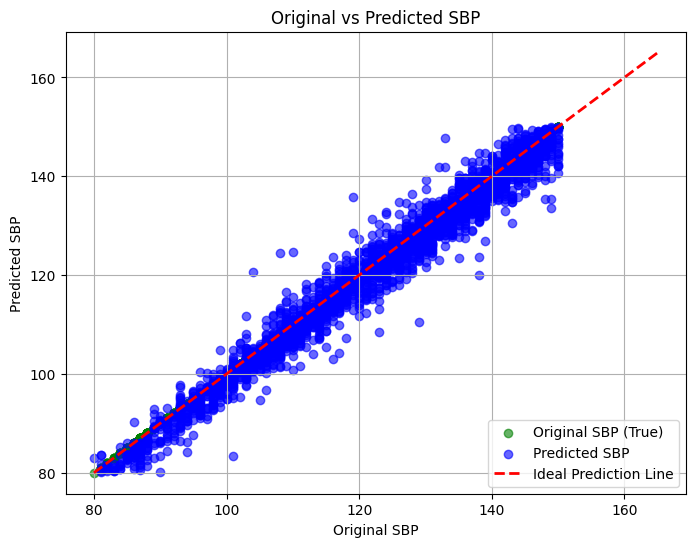

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the SBP valid range
sbp_min, sbp_max = 80, 150

# Filter based on original values
valid_indices_original = (y_test_unscaled[:, 0] >= sbp_min) & (y_test_unscaled[:, 0] <= sbp_max)
y_test_filtered_original = y_test_unscaled[valid_indices_original]
y_pred_filtered_original = y_pred[valid_indices_original]

# Filter based on predicted values
valid_indices_pred = (y_pred_filtered_original[:, 0] >= sbp_min) & (y_pred_filtered_original[:, 0] <= sbp_max)
y_test_filtered_final = y_test_filtered_original[valid_indices_pred]
y_pred_filtered_final = y_pred_filtered_original[valid_indices_pred]

# Create Scatter Plot with Different Colors
plt.figure(figsize=(8, 6))

# Original SBP (Ground Truth) in **Blue**
plt.scatter(y_test_filtered_final[:, 0], y_test_filtered_final[:, 0],
            alpha=0.6, label="Original SBP (True)", color='green', marker='o')

# Predicted SBP in **Green**
plt.scatter(y_test_filtered_final[:, 0], y_pred_filtered_final[:, 0],
            alpha=0.6, label="Predicted SBP", color='blue', marker='o')

# Ideal Prediction Line in **Red Dashed**
x_vals = np.linspace(min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0]) + 15, 50)
plt.plot(x_vals, x_vals, color='red', linestyle='dashed', linewidth=2, label="Ideal Prediction Line")

# Labels & Title
plt.xlabel("Original SBP")
plt.ylabel("Predicted SBP")
plt.title("Original vs Predicted SBP")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


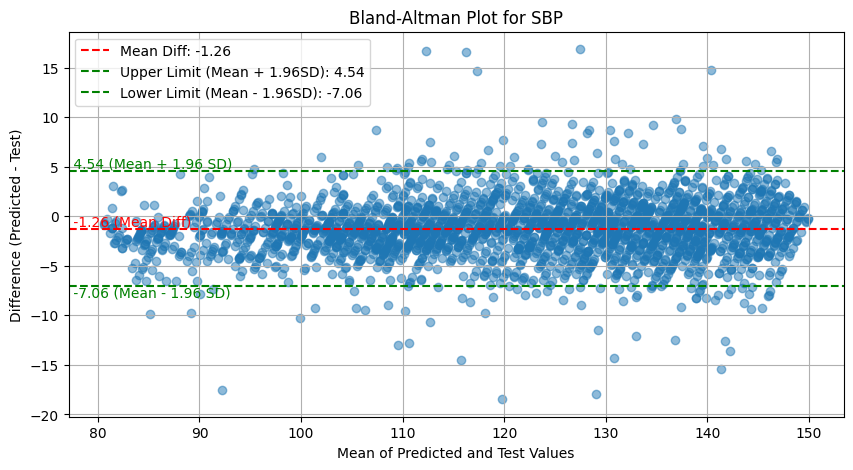

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SBP values (Filtered)
predicted_sbp_filtered = y_pred_filtered_final[:, 0]
test_sbp_filtered = y_test_filtered_final[:, 0]

# Function to create Bland-Altman plot with annotations at the start of lines
def bland_altman_plot(predicted, test, title):
    mean_vals = np.mean(np.array([predicted, test]), axis=0)
    diff_vals = predicted - test
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 5))
    plt.scatter(mean_vals, diff_vals, alpha=0.5)

    # Plot the mean difference line
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.2f}')

    # Plot the upper and lower limit of agreement
    plt.axhline(upper_limit, color='green', linestyle='--', label=f'Upper Limit (Mean + 1.96SD): {upper_limit:.2f}')
    plt.axhline(lower_limit, color='green', linestyle='--', label=f'Lower Limit (Mean - 1.96SD): {lower_limit:.2f}')

    # Get x-axis limit to position text at the start
    x_min, _ = plt.xlim()

    # Add text annotations at the start of each line
    plt.text(x_min, upper_limit, f' {upper_limit:.2f} (Mean + 1.96 SD)',
             verticalalignment='bottom', fontsize=10, color='green')
    plt.text(x_min, lower_limit, f' {lower_limit:.2f} (Mean - 1.96 SD)',
             verticalalignment='top', fontsize=10, color='green')
    plt.text(x_min, mean_diff, f' {mean_diff:.2f} (Mean Diff)',
             verticalalignment='bottom', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel('Mean of Predicted and Test Values')
    plt.ylabel('Difference (Predicted - Test)')
    plt.legend()
    plt.grid()
    plt.show()

# Generate Bland-Altman plot for SBP (Filtered)
bland_altman_plot(predicted_sbp_filtered, test_sbp_filtered, 'Bland-Altman Plot for SBP')


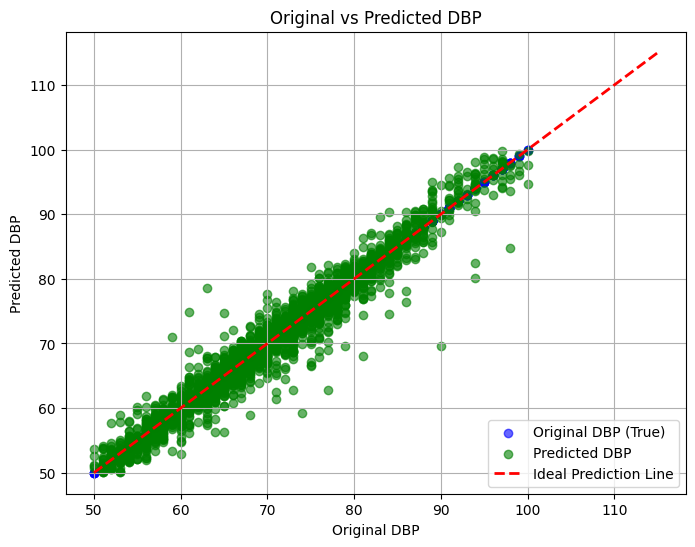

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the DBP valid range
dbp_min, dbp_max = 50, 100

# Filter based on original values
valid_indices_original_dbp = (y_test_unscaled[:, 1] >= dbp_min) & (y_test_unscaled[:, 1] <= dbp_max)
y_test_filtered_original_dbp = y_test_unscaled[valid_indices_original_dbp]
y_pred_filtered_original_dbp = y_pred[valid_indices_original_dbp]

# Filter based on predicted values
valid_indices_pred_dbp = (y_pred_filtered_original_dbp[:, 1] >= dbp_min) & (y_pred_filtered_original_dbp[:, 1] <= dbp_max)
y_test_filtered_final_dbp = y_test_filtered_original_dbp[valid_indices_pred_dbp]
y_pred_filtered_final_dbp = y_pred_filtered_original_dbp[valid_indices_pred_dbp]

# Create Scatter Plot with Different Colors
plt.figure(figsize=(8, 6))

# Original DBP (Ground Truth) in **Blue**
plt.scatter(y_test_filtered_final_dbp[:, 1], y_test_filtered_final_dbp[:, 1],
            alpha=0.6, label="Original DBP (True)", color='blue', marker='o')

# Predicted DBP in **Green**
plt.scatter(y_test_filtered_final_dbp[:, 1], y_pred_filtered_final_dbp[:, 1],
            alpha=0.6, label="Predicted DBP", color='green', marker='o')

# Ideal Prediction Line in **Red Dashed**
x_vals_dbp = np.linspace(min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1]) + 15, 50)
plt.plot(x_vals_dbp, x_vals_dbp, color='red', linestyle='dashed', linewidth=2, label="Ideal Prediction Line")

# Labels & Title
plt.xlabel("Original DBP")
plt.ylabel("Predicted DBP")
plt.title("Original vs Predicted DBP")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


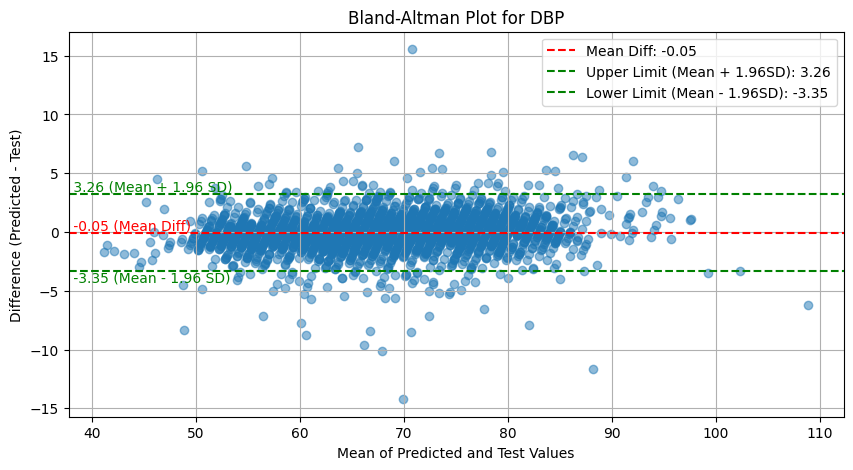

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SBP values (Filtered)
predicted_sbp_filtered = y_pred_filtered_final[:, 1]
test_sbp_filtered = y_test_filtered_final[:, 1]

# Function to create Bland-Altman plot with annotations at the start of lines
def bland_altman_plot(predicted, test, title):
    mean_vals = np.mean(np.array([predicted, test]), axis=0)
    diff_vals = predicted - test
    mean_diff = np.mean(diff_vals)
    std_diff = np.std(diff_vals)

    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 5))
    plt.scatter(mean_vals, diff_vals, alpha=0.5)

    # Plot the mean difference line
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff: {mean_diff:.2f}')

    # Plot the upper and lower limit of agreement
    plt.axhline(upper_limit, color='green', linestyle='--', label=f'Upper Limit (Mean + 1.96SD): {upper_limit:.2f}')
    plt.axhline(lower_limit, color='green', linestyle='--', label=f'Lower Limit (Mean - 1.96SD): {lower_limit:.2f}')

    # Get x-axis limit to position text at the start
    x_min, _ = plt.xlim()

    # Add text annotations at the start of each line
    plt.text(x_min, upper_limit, f' {upper_limit:.2f} (Mean + 1.96 SD)',
             verticalalignment='bottom', fontsize=10, color='green')
    plt.text(x_min, lower_limit, f' {lower_limit:.2f} (Mean - 1.96 SD)',
             verticalalignment='top', fontsize=10, color='green')
    plt.text(x_min, mean_diff, f' {mean_diff:.2f} (Mean Diff)',
             verticalalignment='bottom', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel('Mean of Predicted and Test Values')
    plt.ylabel('Difference (Predicted - Test)')
    plt.legend()
    plt.grid()
    plt.show()

# Generate Bland-Altman plot for SBP (Filtered)
bland_altman_plot(predicted_sbp_filtered, test_sbp_filtered, 'Bland-Altman Plot for DBP')
